In [1]:
from pathlib import Path
import os
import sys
from transformers import AutoProcessor, AutoModelForCausalLM, pipeline
import torch
import random
import numpy as np
import truecase
from datasets import load_from_disk
sys.path.append(str(Path.cwd().parent))

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.utils.dirutils import get_data_dir, get_models_dir
from src.models.multiclassification.predict_model import ViTForMultiClassificationPredictor

# set all seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
multiclassification_model = ViTForMultiClassificationPredictor(
    get_models_dir() / "multiclassification" / "full" / "model-20230513_121917-35.pt",
    DEVICE
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
dataset = load_from_disk(get_data_dir() / "processed" / "captioning_dataset_augmented")["test"]

In [23]:
# my_filenames = [
#     "koloman-moser_picture-book-for-the-niece-of-ditha-mautner-von-markhof-1904-10.jpg",
#     "john-atkinson-grimshaw_under-the-moonbeams-knostrop-hall.jpg",
#     "rene-magritte_the-beautiful-relations-1967.jpg",
#     "giovanni-battista-piranesi_meander-to-the-floor-in-mosaic-found-in-the-country-house.jpg",
#     "francesco-hayez_the-kiss-1859.jpg",
#     "andrea-solario_virgin-and-child.jpg",
#     "paul-jacoulet_les-petits-voleurs-gauche-johokuri-coree-1959.jpg",
#     "philip-guston_painter-in-bed-1973.jpg",
#     "simeon-solomon_king-solomon-1874.jpg",
#     "lucian-freud_queen-elizabeth-ii-2001.jpg",
#     "ivan-aivazovsky_venice-1842-1.jpg",
#     "nasreen-mohamedi_untitled-1970-1.jpg",
#     "jacques-louis-david_napoleon-bonaparte-in-his-study-at-the-tuileries-1812.jpg",
#     "camille-corot_venice-gondola-on-grand-canal.jpg"
# ]
my_filenames = [
    "raden-saleh_lion-attacking-a-horse-1840.jpg",
    "katsushika-hokusai_street-scenes-newly-pubished-4.jpg",
    "vincent-van-gogh_peasant-sitting-by-the-fireplace-worn-out-1881.jpg",
    "frida-kahlo_still-life-1951.jpg",
]

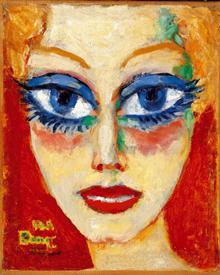

In [7]:
dataset[0]["image"]

In [8]:
def capitalize_artist(s):
    return " ".join([word.capitalize() for word in s.split("-")])

In [9]:
def multiclassification_prediction_to_caption(prediction):
    caption = ""
    multiclass_preds = prediction[0]
    multilabel_preds = prediction[1]

    if multiclass_preds["artist"][0] != "other":
        artist_pred = capitalize_artist(multiclass_preds["artist"][0])
        caption += f"The artwork could be attributed to {artist_pred}, in the {multiclass_preds['genre'][0].capitalize()} genre, showcasing the {multiclass_preds['style'][0].capitalize()} style."
    else:
        caption += f"The artwork could be attributed to an unknown artist, in the {multiclass_preds['genre'][0].capitalize()} genre, showcasing the {multiclass_preds['style'][0].capitalize()} style."

    if multilabel_preds["tags"]:
        caption += f" It is associated with the following concepts: {', '.join(multilabel_preds['tags'])}."

    if multilabel_preds["media"]:
        caption += f" It is presented in the medium of {', '.join(multilabel_preds['media'])}."
    return caption.strip()


In [24]:
captions = {}
for example in dataset:
    if example["file_name"] in my_filenames:
        # display(example["image"])
        prediction = multiclassification_model.predict(example["image"])
        caption = multiclassification_prediction_to_caption(prediction)
        captions[example["file_name"]] = caption

In [11]:
MODEL_NAME = "microsoft/git-base"
PROCESSOR = AutoProcessor.from_pretrained(MODEL_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16)
OUTPUT_DIR = "microsoft_git-base_artgraph"

In [12]:
checkpoint = torch.load(get_models_dir() / "captioning" / "microsoft-git-base-good-samples" / "2.pt")
MODEL.load_state_dict(checkpoint["model_state_dict"])
MODEL.to(DEVICE)
MODEL.train(False)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

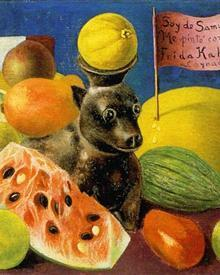

generated caption: a still life composition with a bear and a watermelon, with various fruits and vegetables in the background, and the figure is holding a sign in a vase
The artwork could be attributed to an unknown artist, in the Still life genre, showcasing the Naïve art (primitivism) style. It is associated with the following concepts: Fruit, Still life photography, fruits-and-vegetables. It is presented in the medium of canvas, oil. The artwork depicts A still life composition with a bear and a watermelon, with various fruits and vegetables in the background, and the figure is holding a sign in a vase.
frida-kahlo_still-life-1951.jpg
The artwork depicts a still life composition of various objects, including a watermelon and a pear. 

0.27848467875076965


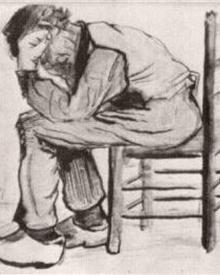

generated caption: a man sitting on a chair, with his head resting on his hand, looking away from the viewer, in a quiet environment with a sense of movement and energy
The artwork could be attributed to an unknown artist, in the Sketch and study genre, showcasing the Realism style. It is associated with the following concepts: Sitting, Sketch. It is presented in the medium of paper, pencil. The artwork depicts A man sitting on a chair, with his head resting on his hand, looking away from the viewer, in a quiet environment with a sense of movement and energy.
vincent-van-gogh_peasant-sitting-by-the-fireplace-worn-out-1881.jpg
The artwork depicts a worn-out peasant sitting by a fireplace in a dimly lit room. 

0.2752224053497905


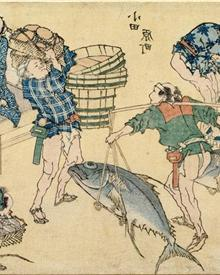

generated caption: a scene from the play of the dead of a man, with a sword and a shield, in a traditional dress and an ancient costume, and holding a basket
The artwork could be attributed to Katsushika Hokusai, in the Genre painting genre, showcasing the Ukiyo-e style. It is presented in the medium of paper. The artwork depicts A scene from the play of the dead of a man, with a sword and a shield, in a traditional dress and an ancient costume, and holding a basket.
katsushika-hokusai_street-scenes-newly-pubished-4.jpg
The artwork depicts a series of street scenes, with people walking, carts and horses passing by, buildings and shops, and a busy and lively atmosphere. 

0.2203959925192157


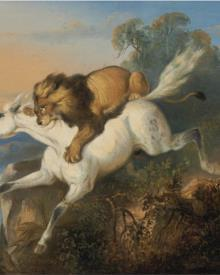

generated caption: a lion and a horse, with a majestic and majestic animal in the background, surrounded by a landscape with trees and mountains in background and clouds in a blue sky
The artwork could be attributed to an unknown artist, in the Animal painting genre, showcasing the Romanticism style. It is associated with the following concepts: Canidae, Fictional character, Mythology. It is presented in the medium of oil. The artwork depicts A lion and a horse, with a majestic and majestic animal in the background, surrounded by a landscape with trees and mountains in background and clouds in a blue sky.
raden-saleh_lion-attacking-a-horse-1840.jpg
The artwork depicts a dramatic scene of a lion attacking a horse in a jungle-like environment. 

0.3239267328199549


In [25]:
from tqdm import tqdm
final_captions = []
for idx, example in enumerate(dataset):
    if example["file_name"] not in captions:
        continue
    image = example["image"]
    display(image)
    pixel_values = PROCESSOR(images=image, return_tensors="pt").pixel_values.to(DEVICE, torch.float16)
    # input_ids = PROCESSOR(images=None, text="a painting of", return_tensors="pt").to(DEVICE)
    generated_ids = MODEL.generate(pixel_values=pixel_values,
                                    # **input_ids,
                                   min_length=30,
                                   max_length=50,
                                   num_beams=1,
                                   no_repeat_ngram_size=2,
                                   do_sample=False,
                                   temperature=0.8,
                                   top_k=50,
                                   )
    generated_caption = PROCESSOR.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"generated caption: {generated_caption}")
    final_captions.append(
        {
            "image_id": idx,
            "caption": generated_caption
        })
    captions[example["file_name"]] += " The artwork depicts " + truecase.get_true_case(generated_caption) + "."
    print(captions[example["file_name"]])
    print(example["file_name"])
    print(example["captions"][0], "\n")
    print(example["clip_score"])

In [ ]:
truecase.get_true_case("the virgin mary holding the child jesus", out_of_vocabulary_token_option="lower")

In [ ]:
# import json
# with open("outputs_good_samples_do_sample_human.jsonl", "w") as f:
#     json.dump(final_captions, f)

In [ ]:
# del MODEL
# del multiclassification_model

In [ ]:
# prompt = list(prompts.values())[0]
# prompt

In [ ]:
# caption = list(captions.values())[0]
# caption

In [ ]:
# from txtai.embeddings import Embeddings

# # Load the index from the HF Hub
# embeddings = Embeddings()
# embeddings.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

# # Run a search
# results = embeddings.search("Berthe Morisot", limit=2)
# results += embeddings.search("Impressionism", limit=1)

In [ ]:
# results